In [ ]:
import fastf1 as ff1
import pandas as pd
from fastf1.core import Laps
from fastf1 import plotting
from fastf1 import utils
from matplotlib import pyplot as plt
from timple.timedelta import strftimedelta
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm


fp = ff1.get_session(2023, 'Belgium', 'Q')
#fp_laps = fp.load_laps(with_telemetry=True)
fp.load()

Text(0.5, 0.98, '2023 Belgian Grand Prix - Qualifying\nFastest Lap: 01:46.168 (VER)')

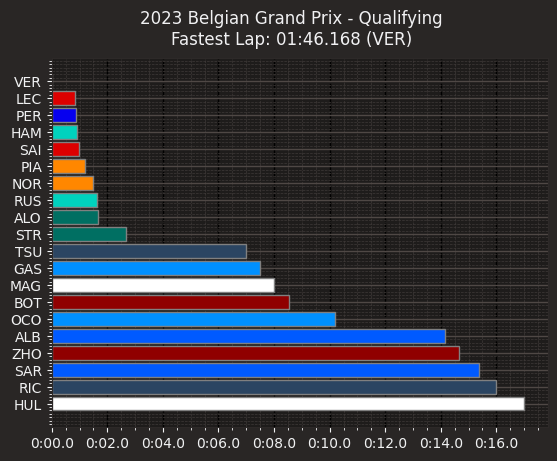

In [2]:
drivers = pd.unique(fp.laps['Driver'])
best_laps = list()
for driver in drivers:
        best_laps.append(fp.laps.pick_driver(driver).pick_fastest())
fastest_laps = Laps(best_laps).sort_values(by='LapTime').reset_index(drop=True)

pole_lap = fastest_laps.pick_fastest()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']

team_colors = list()
for index, lap in fastest_laps.iterlaps():
        color = ff1.plotting.team_color(lap['Team'])
        team_colors.append(color)
        
ff1.plotting.setup_mpl()
fig, ax = plt.subplots()
ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'])

# show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')

plt.suptitle(f"{fp.event.year} {fp.event.EventName} - {fp.name}\n"
             f"Fastest Lap: {lap_time_string} ({pole_lap['Driver']})")


C:\Users\ricca\AppData\Local\Temp\ipykernel_4760\4059958397.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = fastest_drv1.append(fastest_drv2)


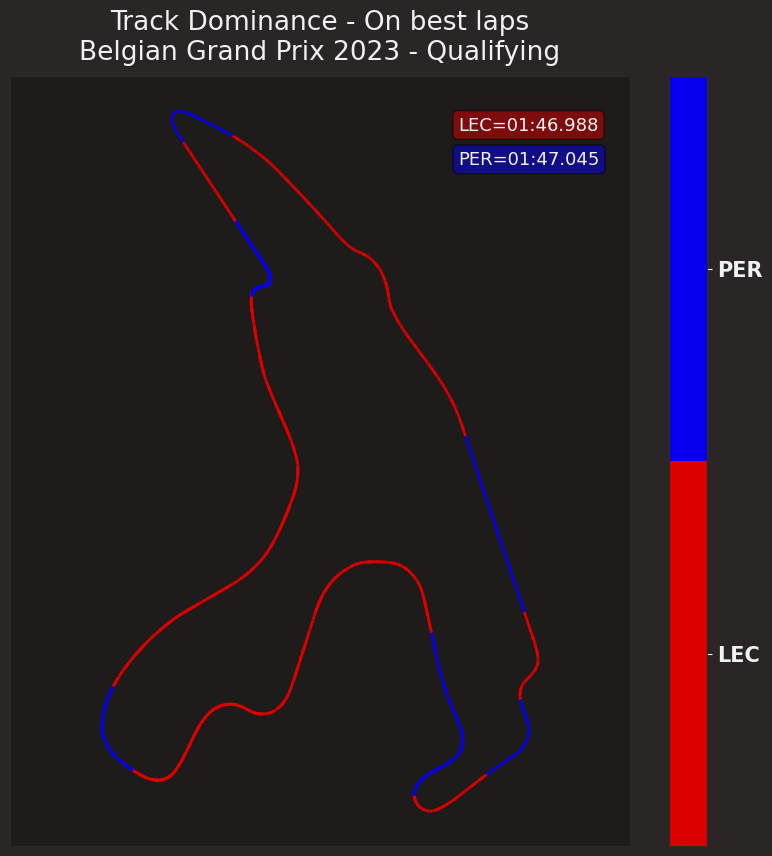

In [16]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
plotting.setup_mpl()
fp_laps = fp.laps
driver1='LEC'
driver2='PER'

color_drv1 = ff1.plotting.team_color('FER')
color_drv2 = ff1.plotting.team_color('RBR')

laps_drv1 = fp_laps.pick_driver(driver1)
laps_drv2 = fp_laps.pick_driver(driver2)


fastest_drv1 = laps_drv1.pick_fastest().get_telemetry().add_distance()
fastest_drv2 = laps_drv2.pick_fastest().get_telemetry().add_distance()

fastest_drv1['Driver'] = driver1
fastest_drv2['Driver'] = driver2

telemetry = fastest_drv1.append(fastest_drv2)

#We want 25 mini-sectors (this can be adjusted up and down)
num_minisectors = 25

# Grab the maximum value of distance that is known in the telemetry
total_distance = total_distance = max(telemetry['Distance'])

# Generate equally sized mini-sectors 
minisector_length = total_distance / num_minisectors

# Initiate minisector variable, with 0 (meters) as a starting point.
minisectors = [0]

# Add multiples of minisector_length to the minisectors
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))


telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

# Select the driver with the highest average speed
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the driver column
fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Convert driver name to integer
telemetry.loc[telemetry['Fastest_driver'] == driver1, 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == driver2, 'Fastest_driver_int'] = 2


x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

#cmap = cm.get_cmap('cool', 4)
cmap = ListedColormap([color_drv1, color_drv2])
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(2)

plt.rcParams['figure.figsize'] = [10, 10]

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
plt.title(f"Track Dominance - On best laps\n"
          f"{fp.event['EventName']} {fp.event.year} - {fp.name}")
cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,4))
cbar.set_ticks(np.arange(1.5, 3.5))
cbar.set_ticklabels([driver1, driver2], fontsize=15, fontweight = 'bold')

plt.text(6000, 4000, f"{driver1}="+str(laps_drv1.pick_fastest().LapTime)[10:19], bbox=dict(boxstyle='round', facecolor=color_drv1, alpha=0.5), fontsize=13)
plt.text(6000, 3000, f"{driver2}="+str(laps_drv2.pick_fastest().LapTime)[10:19], bbox=dict(boxstyle='round', facecolor=color_drv2, alpha=0.5), fontsize=13)
plt.show()

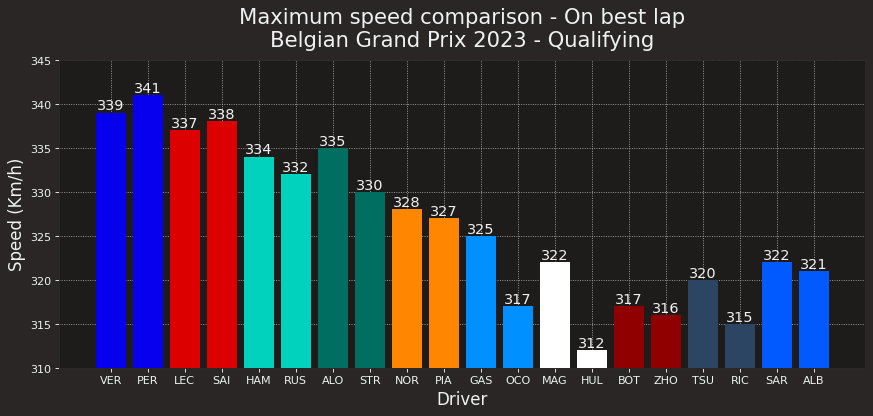

In [7]:
from collections import OrderedDict
fp_laps = fp.laps
#ricavo la lista di tutti i piloti
drivers = pd.unique(fp.laps['Driver'])
#elimino i tempi in cui i piloti erano in giro in o out
fp_laps = fp_laps.loc[(fp_laps['PitOutTime'].isnull() & fp_laps['PitInTime'].isnull() & fp_laps['IsAccurate'] == True)]

#dizionario dove inerirò tutte le massime velocità, le chiavi sono i nom dei piloti 
max_speed_dict = dict.fromkeys(drivers)

for driver in drivers:
        max_speed_dict[driver] = max(fp_laps.pick_driver(driver).pick_fastest().get_car_data()['Speed'])

team_color_drvrs = ['VER', 'PER', 'LEC', 'SAI', 'HAM', 'RUS', 'ALO', 'STR', 'NOR', 'PIA', 'GAS', 'OCO', 'MAG', 'HUL', 'BOT',  'ZHO', 'TSU', 'RIC', 'SAR', 'ALB']
team_colors = [ff1.plotting.team_color('RedBull'),ff1.plotting.team_color('RedBull'), 
               ff1.plotting.team_color('Ferrari'), ff1.plotting.team_color('Ferrari'),
               ff1.plotting.team_color('Mercedes'), ff1.plotting.team_color('Mercedes'),
               ff1.plotting.team_color('Aston Martin'), ff1.plotting.team_color('Aston Martin'),
               ff1.plotting.team_color('McLaren'), ff1.plotting.team_color('McLaren'),
               ff1.plotting.team_color('Alpine'), ff1.plotting.team_color('Alpine'),
               ff1.plotting.team_color('Haas'), ff1.plotting.team_color('Haas'),
               ff1.plotting.team_color('Alfa Romeo'), ff1.plotting.team_color('Alfa Romeo'), 
               ff1.plotting.team_color('Alpha Tauri'), ff1.plotting.team_color('Alpha Tauri'),
               ff1.plotting.team_color('Williams'), ff1.plotting.team_color('Williams'),]

max_speed_dict_ordered = OrderedDict((k, max_speed_dict[k]) for k in team_color_drvrs)
max_speed_dict_ordered = dict(max_speed_dict_ordered)

ff1.plotting.setup_mpl()
figure(figsize=(13, 5), dpi=80)
plt.bar_label(plt.bar(range(len(max_speed_dict_ordered)), list(max_speed_dict_ordered.values()), align='center', color=team_colors), fontsize = 13)
plt.xticks(range(len(max_speed_dict_ordered)), list(max_speed_dict_ordered.keys()))

ax = plt.gca()
ax.set_ylim([310, 345])
plt.title(f"Maximum speed comparison - On best lap\n"
          f"{fp.event['EventName']} {fp.event.year} - {fp.name}")
plt.grid(visible=True, linestyle=':')
plt.xlabel('Driver', fontsize=15)
plt.ylabel('Speed (Km/h)', fontsize=15)
plt.show()

Text(0.5, 1.0, 'Fastest lap comparison\n2023 Belgian Grand Prix - Qualifying\nVER - PER')

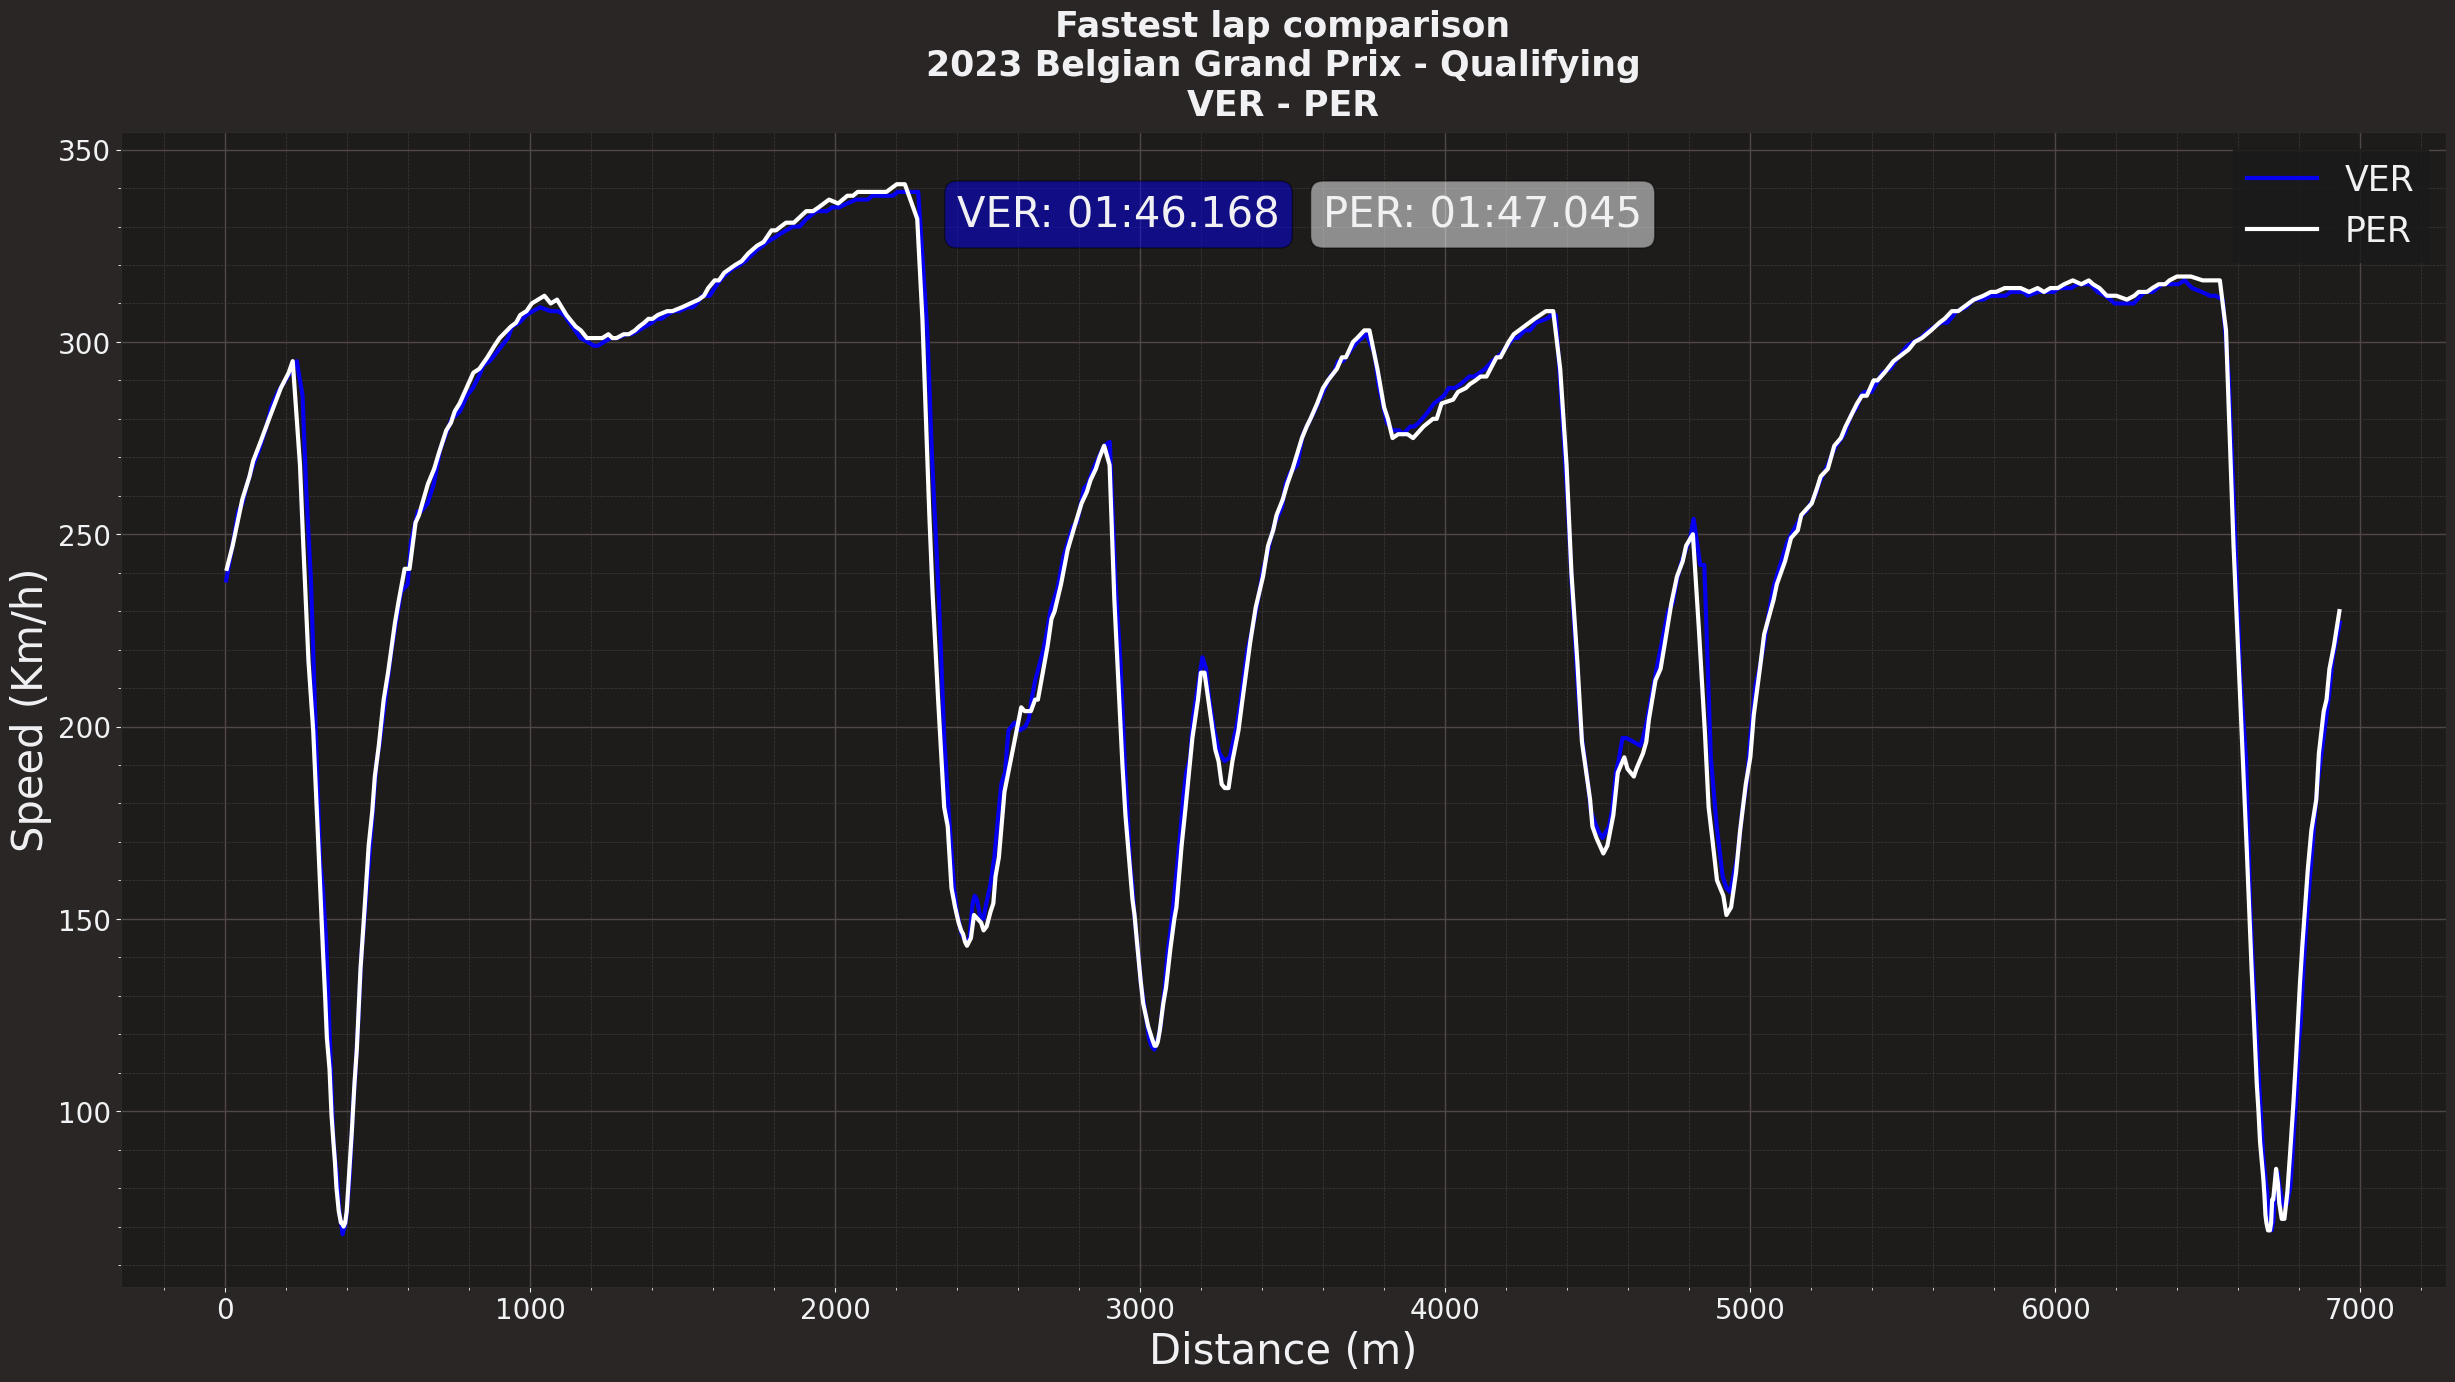

In [21]:
import matplotlib.pyplot as plt
import fastf1.plotting
from math import pi

ff1.plotting.setup_mpl()

ver_lap = fp.laps.pick_driver('VER').pick_fastest()
lec_lap = fp.laps.pick_driver('PER').pick_fastest()

ver_tel = ver_lap.get_car_data().add_distance()
lec_tel = lec_lap.get_car_data().add_distance()

mer_color = ff1.plotting.team_color('RBR')
mer_color2 = "white"

fig1, ax1 = plt.subplots(1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
ax1.plot(ver_tel['Distance'], ver_tel['Speed'], color = mer_color, label = 'VER', linewidth=3)
ax1.plot(lec_tel['Distance'], lec_tel['Speed'], color = mer_color2, label = 'PER', linewidth=3)

ax1.text(2400, 330, "VER: "+str(ver_lap.LapTime)[10:19], fontsize=30, bbox=dict(boxstyle='round', facecolor=mer_color, alpha=0.5))
ax1.text(3600, 330, "PER: "+str(lec_lap.LapTime)[10:19],  fontsize=30, bbox=dict(boxstyle='round', facecolor=mer_color2, alpha=0.5))

ax1.set_xlabel('Distance (m)', size=30)
ax1.set_ylabel('Speed (Km/h)', size=30)
ax1.tick_params(labelsize=20)
ax1.legend(prop={'size': 25})

plt.title(f"Fastest lap comparison\n"f"{fp.event.year} {fp.event.EventName} - {fp.name}\n{ver_lap['Driver']} - {lec_lap['Driver']}", size = 25, weight='bold', ha='center')


C:\Users\ricca\AppData\Local\Temp\ipykernel_4760\2428280210.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = fastest_drv1.append(fastest_drv2)


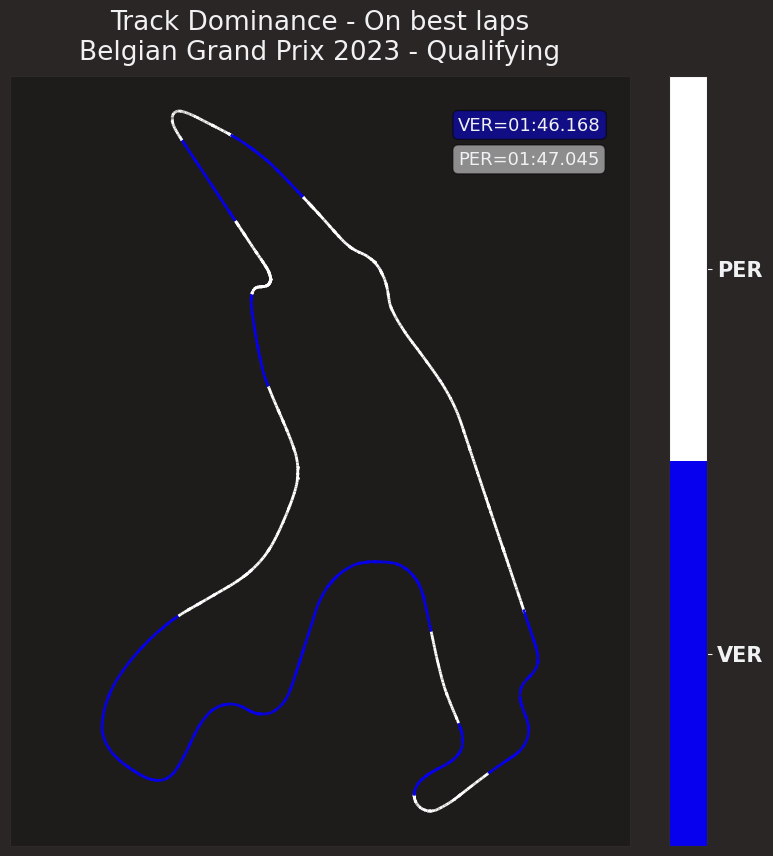

In [17]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
plotting.setup_mpl()
fp_laps = fp.laps
driver1='VER'
driver2='PER'

color_drv1 = ff1.plotting.team_color('RBR')
color_drv2 = "white"

laps_drv1 = fp_laps.pick_driver(driver1)
laps_drv2 = fp_laps.pick_driver(driver2)


fastest_drv1 = laps_drv1.pick_fastest().get_telemetry().add_distance()
fastest_drv2 = laps_drv2.pick_fastest().get_telemetry().add_distance()

fastest_drv1['Driver'] = driver1
fastest_drv2['Driver'] = driver2

telemetry = fastest_drv1.append(fastest_drv2)

#We want 25 mini-sectors (this can be adjusted up and down)
num_minisectors = 25

# Grab the maximum value of distance that is known in the telemetry
total_distance = total_distance = max(telemetry['Distance'])

# Generate equally sized mini-sectors 
minisector_length = total_distance / num_minisectors

# Initiate minisector variable, with 0 (meters) as a starting point.
minisectors = [0]

# Add multiples of minisector_length to the minisectors
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))


telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

# Select the driver with the highest average speed
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the driver column
fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Convert driver name to integer
telemetry.loc[telemetry['Fastest_driver'] == driver1, 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == driver2, 'Fastest_driver_int'] = 2


x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

#cmap = cm.get_cmap('cool', 4)
cmap = ListedColormap([color_drv1, color_drv2])
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(2)

plt.rcParams['figure.figsize'] = [10, 10]

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
plt.title(f"Track Dominance - On best laps\n"
          f"{fp.event['EventName']} {fp.event.year} - {fp.name}")
cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,4))
cbar.set_ticks(np.arange(1.5, 3.5))
cbar.set_ticklabels([driver1, driver2], fontsize=15, fontweight = 'bold')

plt.text(6000, 4000, f"{driver1}="+str(laps_drv1.pick_fastest().LapTime)[10:19], bbox=dict(boxstyle='round', facecolor=color_drv1, alpha=0.5), fontsize=13)
plt.text(6000, 3000, f"{driver2}="+str(laps_drv2.pick_fastest().LapTime)[10:19], bbox=dict(boxstyle='round', facecolor=color_drv2, alpha=0.5), fontsize=13)
plt.show()

Text(0.5, 1.0, 'Fastest lap comparison\n2023 Belgian Grand Prix - Qualifying\nVER - LEC')

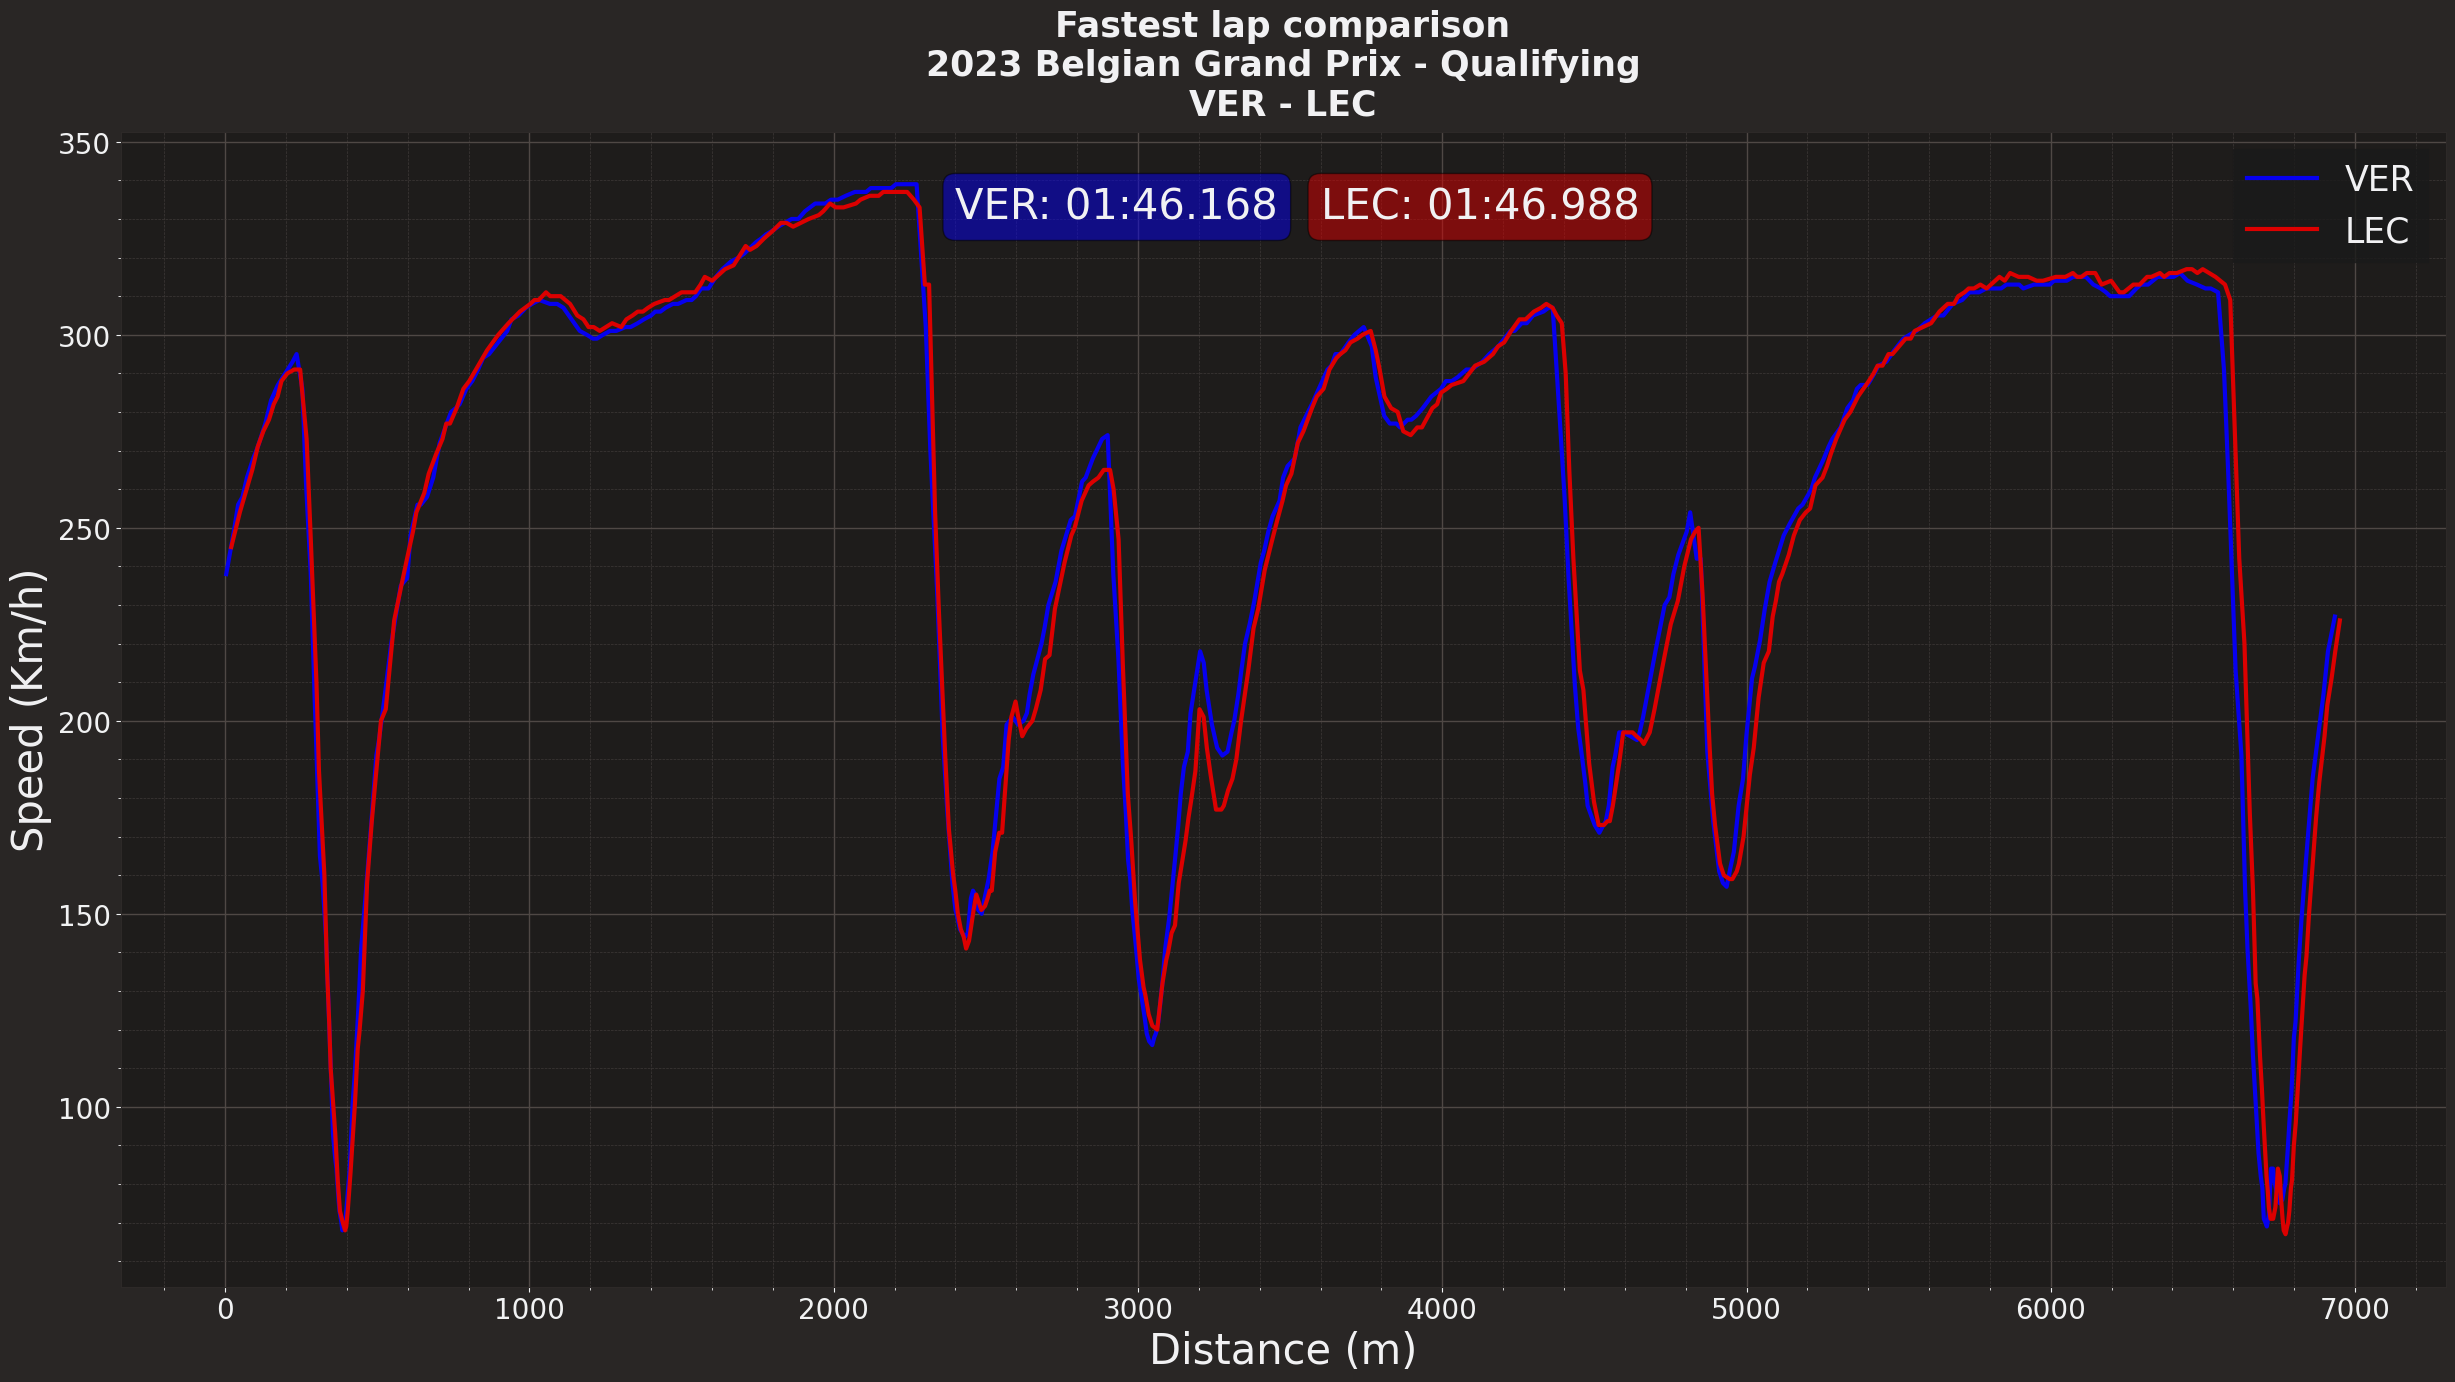

In [22]:
import matplotlib.pyplot as plt
import fastf1.plotting
from math import pi

ff1.plotting.setup_mpl()

ver_lap = fp.laps.pick_driver('VER').pick_fastest()
lec_lap = fp.laps.pick_driver('LEC').pick_fastest()

ver_tel = ver_lap.get_car_data().add_distance()
lec_tel = lec_lap.get_car_data().add_distance()

mer_color = ff1.plotting.team_color('RBR')
mer_color2 = ff1.plotting.team_color('FER')

fig1, ax1 = plt.subplots(1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
ax1.plot(ver_tel['Distance'], ver_tel['Speed'], color = mer_color, label = 'VER', linewidth=3)
ax1.plot(lec_tel['Distance'], lec_tel['Speed'], color = mer_color2, label = 'LEC', linewidth=3)

ax1.text(2400, 330, "VER: "+str(ver_lap.LapTime)[10:19], fontsize=30, bbox=dict(boxstyle='round', facecolor=mer_color, alpha=0.5))
ax1.text(3600, 330, "LEC: "+str(lec_lap.LapTime)[10:19],  fontsize=30, bbox=dict(boxstyle='round', facecolor=mer_color2, alpha=0.5))

ax1.set_xlabel('Distance (m)', size=30)
ax1.set_ylabel('Speed (Km/h)', size=30)
ax1.tick_params(labelsize=20)
ax1.legend(prop={'size': 25})

plt.title(f"Fastest lap comparison\n"f"{fp.event.year} {fp.event.EventName} - {fp.name}\n{ver_lap['Driver']} - {lec_lap['Driver']}", size = 25, weight='bold', ha='center')


c:\Users\ricca\OneDrive\Desktop\F1dataAnalysis\env\Lib\site-packages\fastf1\utils.py:81: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
c:\Users\ricca\OneDrive\Desktop\F1dataAnalysis\env\Lib\site-packages\fastf1\utils.py:81: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
c:\Users\ricca\OneDrive\Desktop\F1dataAnalysis\env\Lib\site-packages\fastf1\utils.py:81: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"


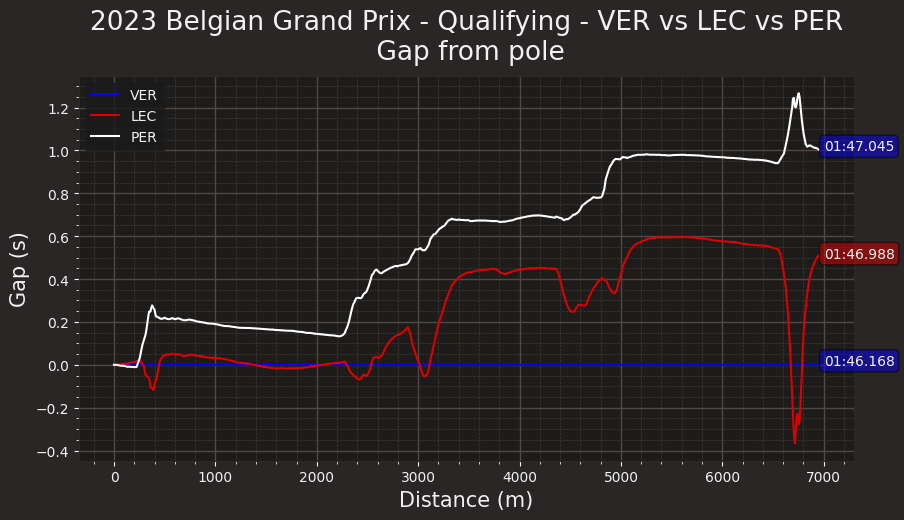

In [25]:
driver_1, driver_2, driver_3 = 'VER', 'LEC', 'PER'
laps_driver_1 = fp.laps.pick_driver(driver_1)
laps_driver_2 = fp.laps.pick_driver(driver_2)
laps_driver_3 = fp.laps.pick_driver(driver_3)

fastest_driver_1 = laps_driver_1.pick_fastest()
fastest_driver_2 = laps_driver_2.pick_fastest()
fastest_driver_3 = laps_driver_3.pick_fastest()

telemetry_driver_1 = fastest_driver_1.get_telemetry().add_distance()
telemetry_driver_2 = fastest_driver_2.get_telemetry().add_distance()
telemetry_driver_3 = fastest_driver_3.get_telemetry().add_distance()

team_driver_1 = fastest_driver_1['Team']
team_driver_2 = fastest_driver_2['Team']
team_driver_3 = fastest_driver_3['Team']

delta_time12, ref_tel12, compare_tel12 = utils.delta_time(fastest_driver_1, fastest_driver_2)
delta_time13, ref_tel13, compare_tel13 = utils.delta_time(fastest_driver_1, fastest_driver_3)
delta_time11, ref_tel11, compare_tel11 = utils.delta_time(fastest_driver_1, fastest_driver_1)

plot_size = [10, 5]
plot_title = f"{fp.event.year} {fp.event.EventName} - {fp.name} - {driver_1} vs {driver_2} vs {driver_3}\n Gap from pole"
plot_ratios = [1]
plotting.setup_mpl()
# Make plot a bit bigger
plt.rcParams['figure.figsize'] = plot_size

# Create subplots with different sizes
fig, ax = plt.subplots(1, gridspec_kw={'height_ratios': plot_ratios})

# Set the plot title
ax.title.set_text(plot_title)

# Delta line
ax.plot(ref_tel11['Distance'], delta_time11, color=ff1.plotting.team_color(team_driver_1), label= driver_1)
ax.plot(ref_tel12['Distance'], delta_time12, color=ff1.plotting.team_color(team_driver_2), label= driver_2)
ax.plot(ref_tel13['Distance'], delta_time13, color="white", label = driver_3)

ax.text(7000, 0, str(fastest_driver_1.LapTime)[10:19], fontsize=10, bbox=dict(boxstyle='round', facecolor=ff1.plotting.team_color(team_driver_1), alpha=0.5))
ax.text(7000, 0.5, str(fastest_driver_2.LapTime)[10:19], fontsize=10, bbox=dict(boxstyle='round', facecolor=ff1.plotting.team_color(team_driver_2), alpha=0.5))
ax.text(7000, 1, str(fastest_driver_3.LapTime)[10:19], fontsize=10, bbox=dict(boxstyle='round', facecolor=ff1.plotting.team_color(team_driver_3), alpha=0.5))

ax.set_ylabel("Gap (s)", fontsize = 10)
ax.set_xlabel("Distance (m)", fontsize=10)
ax.yaxis.label.set_size(15)
ax.xaxis.label.set_size(15)
ax.legend(loc="upper left", prop={'size': 10})

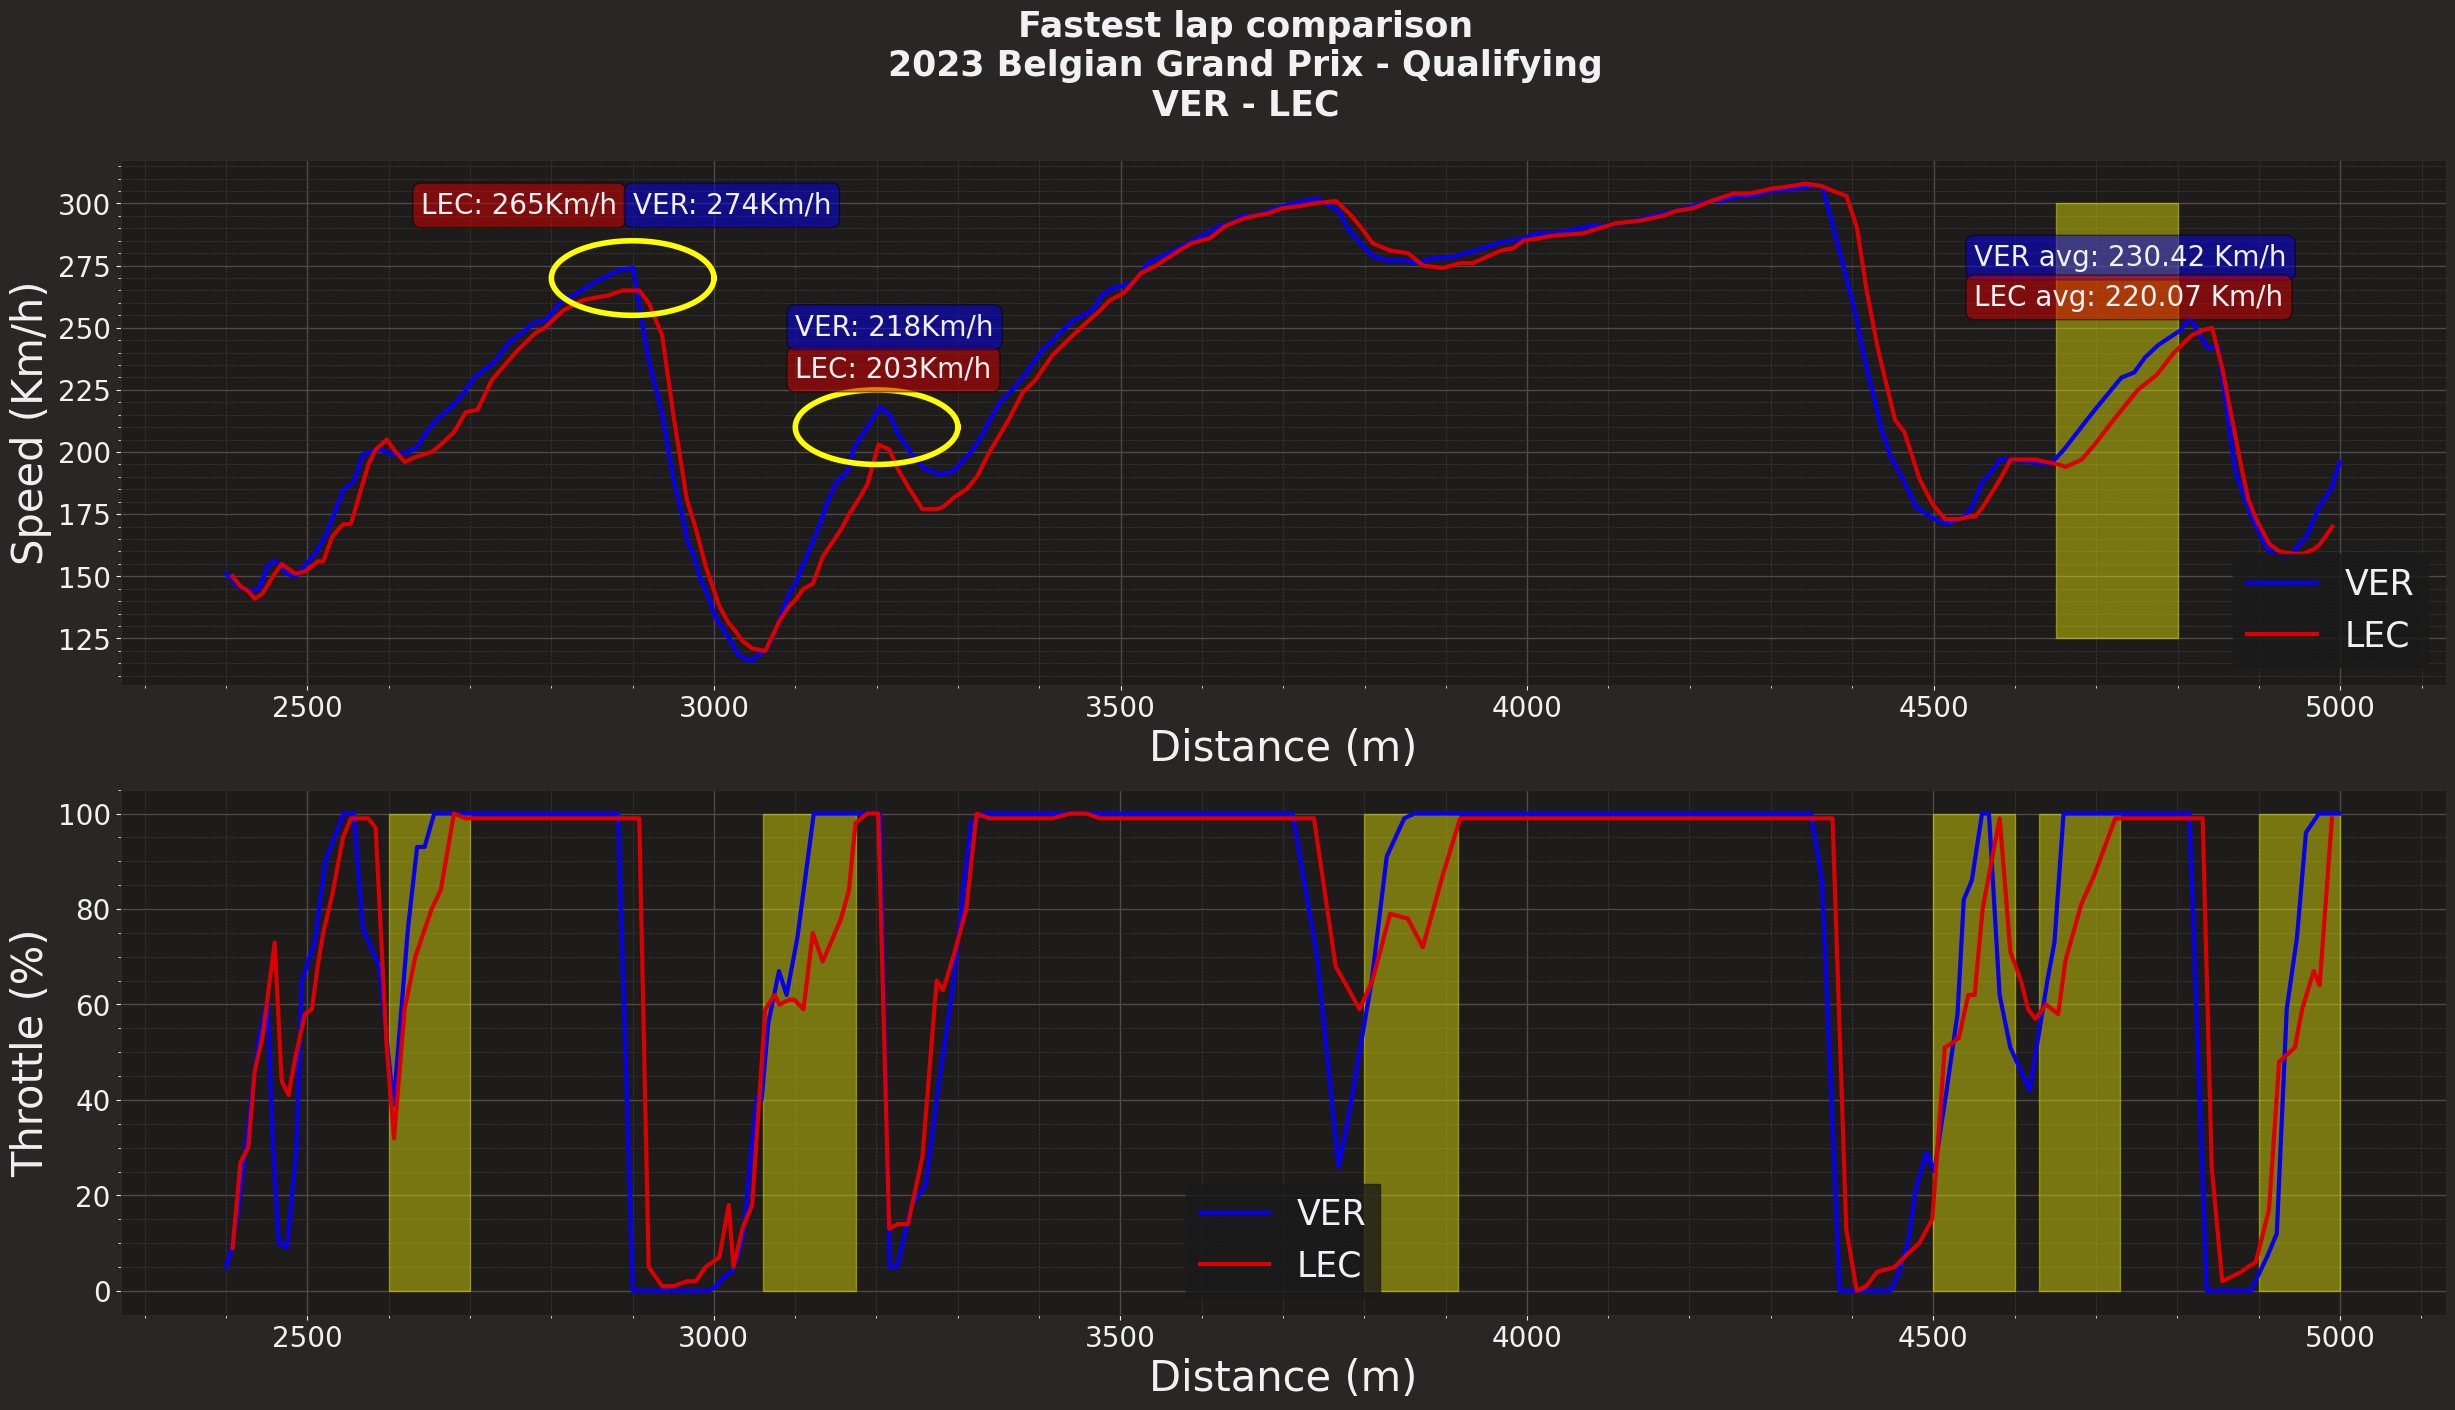

In [2]:
import matplotlib.pyplot as plt
import fastf1.plotting
from math import pi
from matplotlib.patches import Rectangle

ff1.plotting.setup_mpl()

ver_lap = fp.laps.pick_driver('VER').pick_fastest()
lec_lap = fp.laps.pick_driver('LEC').pick_fastest()

ver_tel = ver_lap.get_car_data().add_distance()
lec_tel = lec_lap.get_car_data().add_distance()

ver_tel = ver_tel[ver_tel['Distance'].between(2400, 5000)]
lec_tel = lec_tel[lec_tel['Distance'].between(2400, 5000)]

mer_color = ff1.plotting.team_color('RBR')
mer_color2 = ff1.plotting.team_color('FER')

fig1, ax1 = plt.subplots(2)
fig1.set_figheight(15)
fig1.set_figwidth(30)
fig1.suptitle(f"Fastest lap comparison\n"f"{fp.event.year} {fp.event.EventName} - {fp.name}\n{ver_lap['Driver']} - {lec_lap['Driver']}", size = 25, weight='bold', ha='center')

ax1[0].plot(ver_tel['Distance'], ver_tel['Speed'], color = mer_color, label = 'VER', linewidth=3)
ax1[0].plot(lec_tel['Distance'], lec_tel['Speed'], color = mer_color2, label = 'LEC', linewidth=3)

ver_tel_speed = ver_tel.query('Distance >= 2900')['Speed'].iloc[0]
lec_tel_speed = lec_tel.query('Distance >= 2900')['Speed'].iloc[0]

ax1[0].text(x=2640, y = 296, s = "LEC: " + str(lec_tel_speed) +"Km/h", fontsize=20, bbox=dict(boxstyle='round', facecolor=mer_color2, alpha=0.5))
ax1[0].text(x=2900, y = 296, s = "VER: " + str(ver_tel_speed) +"Km/h", fontsize=20, bbox=dict(boxstyle='round', facecolor=mer_color, alpha=0.5))

u=2900     #x-position of the center
v=270    #y-position of the center
a=100    #radius on the x-axis
b=15    #radius on the y-axis
t = np.linspace(0, 2*pi, 100)
ax1[0].plot( u+a*np.cos(t) , v+b*np.sin(t), color="yellow", linewidth=4)

ver_tel_speed = ver_tel.query('Distance >= 3200')['Speed'].iloc[0]
lec_tel_speed = lec_tel.query('Distance >= 3200')['Speed'].iloc[0]

ax1[0].text(x=3100, y = 230, s = "LEC: " + str(lec_tel_speed) +"Km/h", fontsize=20, bbox=dict(boxstyle='round', facecolor=mer_color2, alpha=0.5))
ax1[0].text(x=3100, y = 247, s = "VER: " + str(ver_tel_speed) +"Km/h", fontsize=20, bbox=dict(boxstyle='round', facecolor=mer_color, alpha=0.5))

u=3200     #x-position of the center
v=210    #y-position of the center
a=100    #radius on the x-axis
b=15    #radius on the y-axis
t = np.linspace(0, 2*pi, 100)
ax1[0].plot( u+a*np.cos(t) , v+b*np.sin(t), color="yellow", linewidth=4)

first_ver_time=ver_tel.loc[ver_tel['Distance'] >= 4650, 'Time'].iloc[0] #912
last_ver_time=ver_tel.loc[ver_tel['Distance'] >= 4800, 'Time'].iloc[0] #1505
diff_sai_time = last_ver_time - first_ver_time
distance_travelled_ver = ver_tel.loc[ver_tel['Time'] == last_ver_time, 'Distance'].iloc[0] - ver_tel.loc[ver_tel['Time'] == first_ver_time, 'Distance'].iloc[0]
mean_speed_ver = (distance_travelled_ver)/(diff_sai_time.total_seconds())
ver_mean_kmh = mean_speed_ver*3.6

first_lec_time=lec_tel.loc[lec_tel['Distance'] >= 4650, 'Time'].iloc[0] #912
last_lec_time=lec_tel.loc[lec_tel['Distance'] >= 4800, 'Time'].iloc[0] #1505
diff_lec_time = last_lec_time - first_lec_time
distance_travelled = lec_tel.loc[lec_tel['Time'] == last_lec_time, 'Distance'].iloc[0] - lec_tel.loc[lec_tel['Time'] == first_lec_time, 'Distance'].iloc[0]
mean_speed_lec = (distance_travelled)/(diff_lec_time.total_seconds())
lec_mean_kmh=mean_speed_lec*3.6

ax1[0].text(4550, 275, "VER avg: "+str(ver_mean_kmh)[0:6]+" Km/h", fontsize=20, bbox=dict(boxstyle='round', facecolor=mer_color, alpha=0.5))
ax1[0].text(4550, 259, "LEC avg: "+str(lec_mean_kmh)[0:6]+" Km/h", fontsize=20, bbox=dict(boxstyle='round', facecolor=mer_color2, alpha=0.5))
ax1[0].add_patch(Rectangle((4650, 125), 150, 175, color='yellow', alpha=0.4))


ax1[0].set_xlabel('Distance (m)', size=30)
ax1[0].set_ylabel('Speed (Km/h)', size=30)
ax1[0].tick_params(labelsize=20)
ax1[0].legend(prop={'size': 25}, loc='lower right')



ax1[1].plot(ver_tel['Distance'], ver_tel['Throttle'], color = mer_color, label = 'VER', linewidth=3)
ax1[1].plot(lec_tel['Distance'], lec_tel['Throttle'], color = mer_color2, label = 'LEC', linewidth=3)

ax1[1].add_patch(Rectangle((2600, 0), 100, 100, color='yellow', alpha=0.4))
ax1[1].add_patch(Rectangle((3060, 0), 115, 100, color='yellow', alpha=0.4))
ax1[1].add_patch(Rectangle((3800, 0), 115, 100, color='yellow', alpha=0.4))
ax1[1].add_patch(Rectangle((4500, 0), 100, 100, color='yellow', alpha=0.4))
ax1[1].add_patch(Rectangle((4630, 0), 100, 100, color='yellow', alpha=0.4))
ax1[1].add_patch(Rectangle((4900, 0), 100, 100, color='yellow', alpha=0.4))

ax1[1].set_xlabel('Distance (m)', size=30)
ax1[1].set_ylabel('Throttle (%)', size=30)
ax1[1].tick_params(labelsize=20)
ax1[1].legend(prop={'size': 25})

